# SMIB system as in Milano's book example 8.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt

In [2]:
%matplotlib notebook

## Import system module

In [3]:
from smib_milano_ex8p1 import smib_milano_ex8p1_class,daesolver

## Instantiate system

In [4]:
syst = smib_milano_ex8p1_class()
syst.t_end = 15.0
syst.Dt = 0.05
syst.decimation =1
syst.update()

## Solution function

In [25]:
def test(syst,use_numba=True):
    # simulation parameters
    syst.struct[0].imax = 50    # maximum number of iterations
    syst.struct[0].itol = 1e-8  # relative tolerance to stop iteration
    syst.struct[0].solvern = 5  # 5 = DAE trapezoidal solver (fixed step)
    syst.struct[0].it = 0       # set time step to zero
    syst.struct[0].it_store = 0 # set storage to zero
    syst.struct[0].t = 0.0      # set time to zero
    
    syst.struct[0].D = 5
    
    # compute initial conditions using x and y_ini 
    xy0 = np.ones(syst.N_x+syst.N_y)
    xy = sopt.fsolve(syst.ini_problem,xy0 )

    # from ini system to run system
    syst.struct[0].p_m = xy[syst.xy_ini_list.index('p_m')]
    syst.struct[0].e1q = xy[syst.xy_ini_list.index('e1q')]

    syst.struct[0].x[:,0] = xy[0:syst.N_x]
    syst.struct[0].y[:,0] = xy[syst.N_x:]

    syst.struct[0].y[syst.y_list.index('P_t'),0] = syst.struct.P_t
    syst.struct[0].y[syst.y_list.index('Q_t'),0] = syst.struct.Q_t
    
    # solve system

    if use_numba:  # using numba
        syst.struct.t_end = 1.0  
        daesolver(syst.struct)    # run until 1 s
        syst.struct[0].p_m = 0.4  # apply step in mechanical power p_m
        syst.struct.t_end = 10.0  
        daesolver(syst.struct)    # run until 10 s
    else:  # without using numba
        syst.struct.t_end = 1.0  
        daesolver.py_func(syst.struct)    # run until 1 s
        syst.struct[0].p_m = 0.4  # apply step in mechanical power p_m
        syst.struct.t_end = 10.0  
        daesolver.py_func(syst.struct)    # run until 10 s     


### Benchmark without numba

In [26]:
%timeit test(syst,use_numba=False)

313 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Benchmark using numba

In [27]:
%timeit test(syst,use_numba=True)

5.95 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Run test

In [28]:
test(syst,use_numba=True)

### Results extraction

In [29]:
T = syst.struct[0]['T'][:syst.struct[0].it_store]
X = syst.struct[0]['X'][:syst.struct[0].it_store,:]
Y = syst.struct[0]['Y'][:syst.struct[0].it_store,:]

### Results plots

<IPython.core.display.Javascript object>


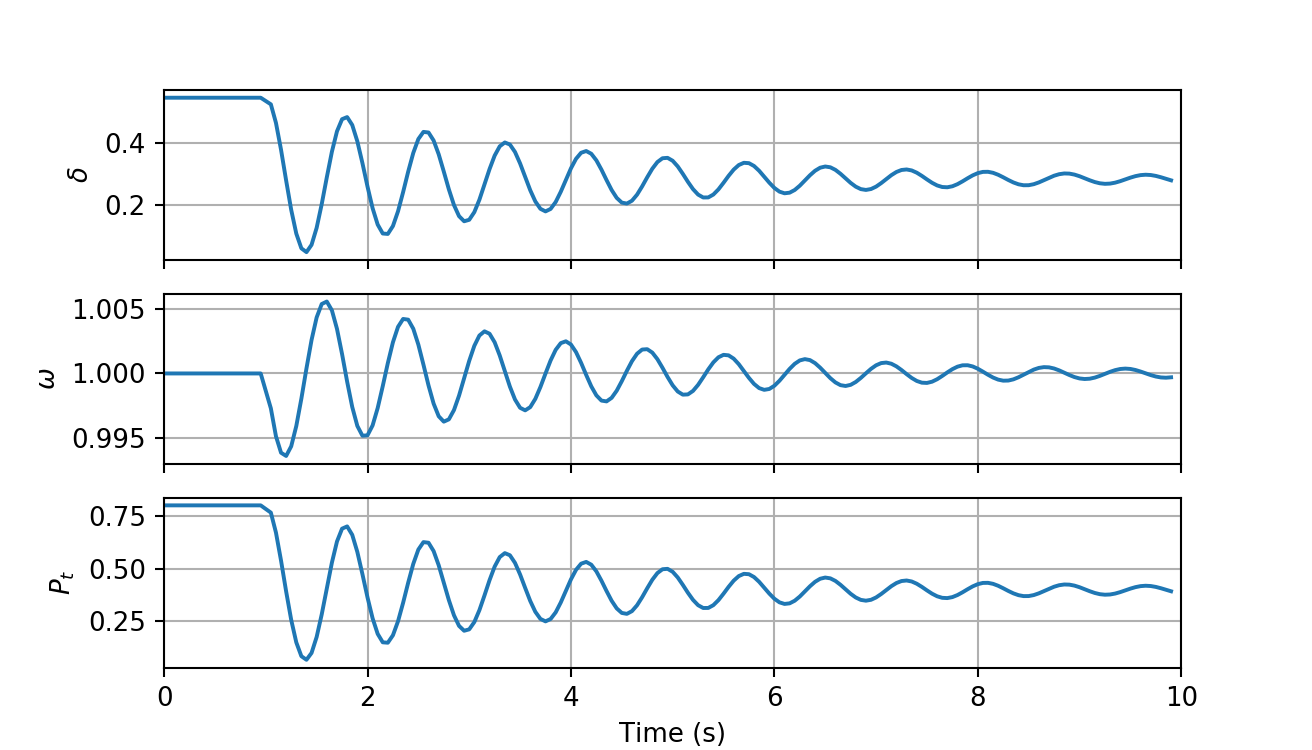

Text(0.5, 0, 'Time (s)')

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)
axes[0].plot(T, X[:,syst.x_list.index('delta')])
axes[1].plot(T, X[:,syst.x_list.index('omega')])
axes[2].plot(T, Y[:,syst.y_list.index('P_t')])

y_labels = ['$\delta$','$\omega$','$P_t$']
for ax,y_label in zip(axes,y_labels):
    ax.set_ylabel(y_label)
    ax.set_xlim((0,10))
    ax.grid(True)
ax.set_xlabel('Time (s)')    


In [24]:
syst.struct[0].D

1.0